In [1]:
from keras.applications.mobilenet import MobileNet
import pandas as pd
import numpy as np
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib import pyplot as plt
from sklearn.decomposition import PCA
import pylab as pl
import scipy.optimize as opt
from sklearn import preprocessing
%matplotlib inline
import cv2
import random
from PIL import Image
import os
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Flatten, Dense, GlobalMaxPooling2D, Dropout
from keras.models import Model
from keras import optimizers
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.callbacks import ModelCheckpoint
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras import layers

In [4]:
DATA_DIR = '../input/large-gender-face-dataset/big_face_gender_data'
print(os.listdir(path=DATA_DIR))

['Validation', 'Test', 'Train']


In [2]:
batch_size = 256         
shape = (218,178)

def add_noise(img):
    VARIABILITY = 50
    deviation = VARIABILITY*random.random()
    noise = np.random.normal(0, deviation, img.shape)
    img += noise
    np.clip(img, 0., 255.)
    return img

train_datagen = ImageDataGenerator(rescale = 1./255, rotation_range=20,shear_range = 0.2,
                                   zoom_range = 0.2, horizontal_flip = True,
                                   width_shift_range=0.2, height_shift_range=0.2,
                                   fill_mode='nearest', preprocessing_function=add_noise)
train = train_datagen.flow_from_directory(directory='../input/large-gender-face-dataset/big_face_gender_data/Train',
                                       target_size=shape, batch_size=batch_size,
                                       class_mode='binary', color_mode='rgb', shuffle=True)

validation_datagen = ImageDataGenerator(rescale=1./255)
val = validation_datagen.flow_from_directory(directory='../input/large-gender-face-dataset/big_face_gender_data/Validation',
                                          target_size=shape, batch_size=batch_size,
                                          class_mode='binary', color_mode='rgb', shuffle=True)

Found 181665 images belonging to 2 classes.
Found 17765 images belonging to 2 classes.


In [6]:
img, label = train.next()
print(img[1].shape)

(218, 178, 3)


In [7]:
print('Len(train):',len(train))
print('len(val):', len(val))

Len(train): 355
len(val): 35


In [8]:
print(train.class_indices)
train.classes

{'Female': 0, 'Male': 1}


array([0, 0, 0, ..., 1, 1, 1], dtype=int32)

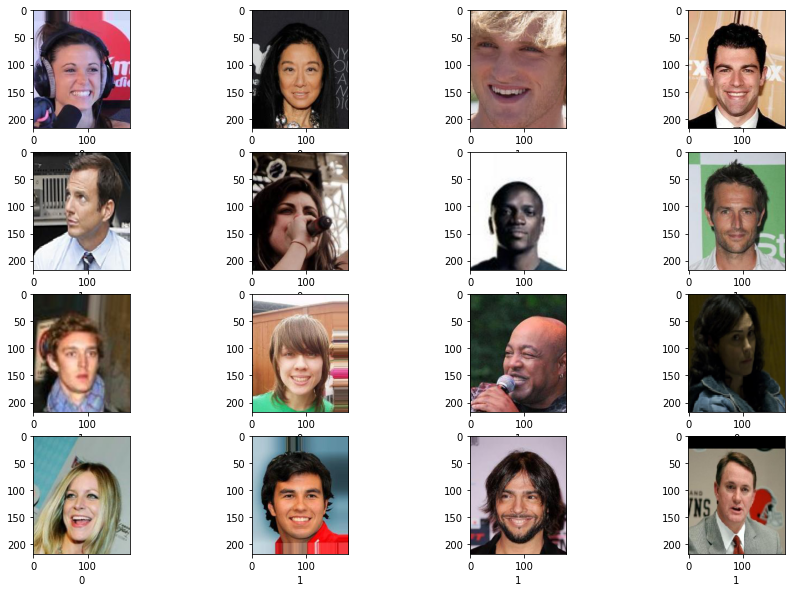

In [9]:
# Show image
img, label = train.next()

fig = plt.figure(figsize=(15,10))
for i in range(1,17):
    plt.subplot(4,4,i)
    plt.imshow(img[i])
    plt.xlabel( int(label[i]))
plt.show()

# Buil Model MobileNet

In [2]:
input_shape = (218, 178, 3)
pre_trained_model = MobileNet(input_shape=input_shape, include_top=False, weights="imagenet")
for i,layer in enumerate(pre_trained_model.layers):
    print(i,layer.name)
print("\nInput:", pre_trained_model.input)
print("Output:", pre_trained_model.output)

2022-10-29 11:39:32.395529: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


17235968/17225924 [==============================] - 0s 0us/step
0 input_1
1 conv1
2 conv1_bn
3 conv1_relu
4 conv_dw_1
5 conv_dw_1_bn
6 conv_dw_1_relu
7 conv_pw_1
8 conv_pw_1_bn
9 conv_pw_1_relu
10 conv_pad_2
11 conv_dw_2
12 conv_dw_2_bn
13 conv_dw_2_relu
14 conv_pw_2
15 conv_pw_2_bn
16 conv_pw_2_relu
17 conv_dw_3
18 conv_dw_3_bn
19 conv_dw_3_relu
20 conv_pw_3
21 conv_pw_3_bn
22 conv_pw_3_relu
23 conv_pad_4
24 conv_dw_4
25 conv_dw_4_bn
26 conv_dw_4_relu
27 conv_pw_4
28 conv_pw_4_bn
29 conv_pw_4_relu
30 conv_dw_5
31 conv_dw_5_bn
32 conv_dw_5_relu
33 conv_pw_5
34 conv_pw_5_bn
35 conv_pw_5_relu
36 conv_pad_6
37 conv_dw_6
38 conv_dw_6_bn
39 conv_dw_6_relu
40 conv_pw_6
41 conv_pw_6_bn
42 conv_pw_6_relu
43 conv_dw_7
44 conv_dw_7_bn
45 conv_dw_7_relu
46 conv_pw_7
47 conv_pw_7_bn
48 conv_pw_7_relu
49 conv_dw_8
50 conv_dw_8_bn
51 conv_dw_8_relu
52 conv_pw_8
53 conv_pw_8_bn
54 conv_pw_8_relu
55 conv_dw_9
56 conv_dw_9_bn
57 conv_dw_9_relu
58 conv_pw_9
59 conv_pw_9_bn
60 conv_pw_9_relu
61 conv_dw_

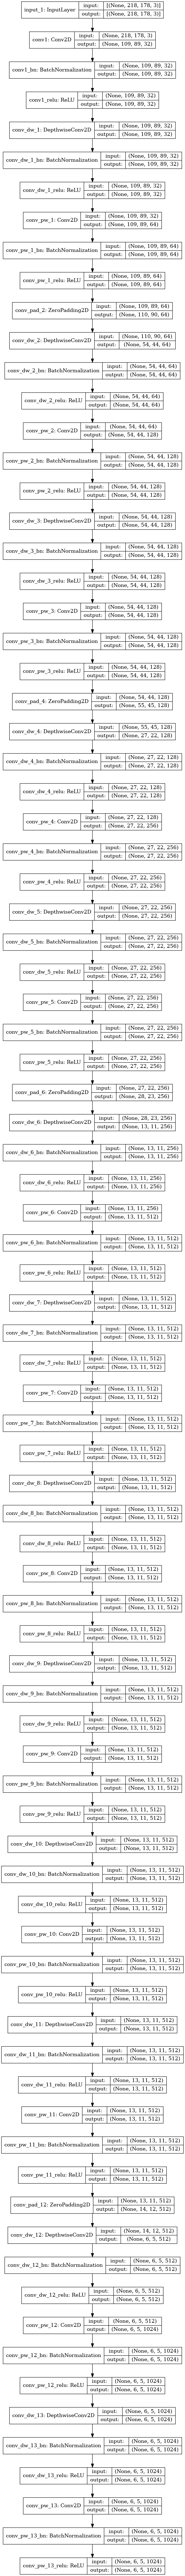

In [3]:
# Visualation Mobile Net architecture
from tensorflow.keras.utils import plot_model
plot_model(pre_trained_model,show_shapes=True, show_layer_names=True, rankdir='TB', expand_nested=True)

# Train Model

In [4]:
input_shape = (218, 178, 3)

pre_trained_model = MobileNet(input_shape=input_shape, include_top=False, weights="imagenet")

last_output = pre_trained_model.output
# Flatten the output layer to 1 dimension
x = GlobalMaxPooling2D()(last_output)
# Add a fully connected layer with 512 hidden units and ReLU activation
x = Dense(512, activation='relu')(x)
x = Dropout(0.2)(x)  # Dropout layer to reduce overfitting
# Add a final sigmoid layer for classification
x = Dense(1, activation='sigmoid')(x)

model = Model(inputs=pre_trained_model.input, outputs=x)
    
model.compile(keras.optimizers.Adagrad(learning_rate=0.001), 
              loss = 'binary_crossentropy', 
              metrics=['accuracy'])

model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 218, 178, 3)]     0         
_________________________________________________________________
conv1 (Conv2D)               (None, 109, 89, 32)       864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 109, 89, 32)       128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 109, 89, 32)       0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 109, 89, 32)       288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 109, 89, 32)       128       
_________________________________________________________________
conv_dw_1_relu (ReLU)        (None, 109, 89, 32)       0   

In [16]:
checkpoint = ModelCheckpoint('training_save.h5', verbose=1, mode='auto',
                                              monitor='val_accuracy',  
                                              save_best_only=True)

history = model.fit_generator(
    train, epochs=20,
    validation_data=val,
    verbose=1, callbacks=[checkpoint])

Epoch 1/20
194/710 [=======>......................] - ETA: 21:37 - loss: 0.4661 - accuracy: 0.8571

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


710/710 [==============================] - 2064s 3s/step - loss: 0.2730 - accuracy: 0.9087 - val_loss: 0.1206 - val_accuracy: 0.9560

Epoch 00001: val_accuracy improved from -inf to 0.95598, saving model to training_save.h5
Epoch 2/20
710/710 [==============================] - 955s 1s/step - loss: 0.1189 - accuracy: 0.9553 - val_loss: 0.0990 - val_accuracy: 0.9636

Epoch 00002: val_accuracy improved from 0.95598 to 0.96364, saving model to training_save.h5
Epoch 3/20
710/710 [==============================] - 856s 1s/step - loss: 0.0889 - accuracy: 0.9675 - val_loss: 0.0920 - val_accuracy: 0.9658

Epoch 00003: val_accuracy improved from 0.96364 to 0.96583, saving model to training_save.h5
Epoch 4/20
710/710 [==============================] - 843s 1s/step - loss: 0.0731 - accuracy: 0.9728 - val_loss: 0.0872 - val_accuracy: 0.9683

Epoch 00004: val_accuracy improved from 0.96583 to 0.96825, saving model to training_save.h5
Epoch 5/20
710/710 [==============================] - 829s 1s/ste

In [6]:
checkpoint = ModelCheckpoint('training_save.h5', verbose=1, mode='auto',
                                              monitor='val_accuracy',  
                                              save_best_only=True)

history = model.fit_generator(
    train, epochs=20,
    validation_data=val,
    verbose=1, callbacks=[checkpoint])

/opt/conda/lib/python3.7/site-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '
2022-10-30 00:30:43.500609: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/20


2022-10-30 00:30:47.218141: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


 75/710 [==>...........................] - ETA: 20:16 - loss: 0.0108 - accuracy: 0.9977

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


710/710 [==============================] - 1435s 2s/step - loss: 0.0113 - accuracy: 0.9974 - val_loss: 0.0828 - val_accuracy: 0.9743

Epoch 00001: val_accuracy improved from -inf to 0.97433, saving model to training_save.h5
Epoch 2/20
710/710 [==============================] - 801s 1s/step - loss: 0.0106 - accuracy: 0.9975 - val_loss: 0.0831 - val_accuracy: 0.9744

Epoch 00002: val_accuracy improved from 0.97433 to 0.97444, saving model to training_save.h5
Epoch 3/20
710/710 [==============================] - 804s 1s/step - loss: 0.0096 - accuracy: 0.9979 - val_loss: 0.0831 - val_accuracy: 0.9748

Epoch 00003: val_accuracy improved from 0.97444 to 0.97478, saving model to training_save.h5
Epoch 4/20
710/710 [==============================] - 797s 1s/step - loss: 0.0089 - accuracy: 0.9980 - val_loss: 0.0844 - val_accuracy: 0.9750

Epoch 00004: val_accuracy improved from 0.97478 to 0.97495, saving model to training_save.h5
Epoch 5/20
710/710 [==============================] - 807s 1s/ste

In [17]:
print(history.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:17: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  app.launch_new_instance()


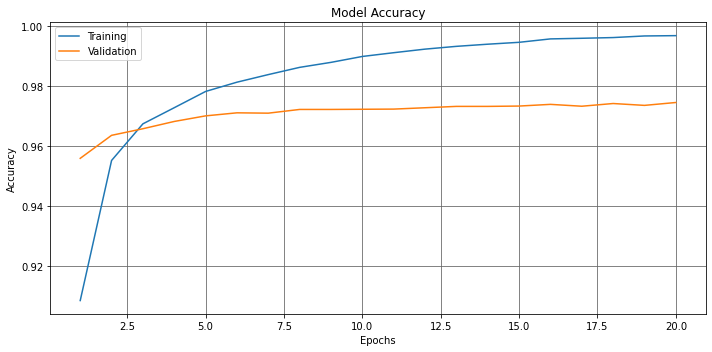

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:29: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.


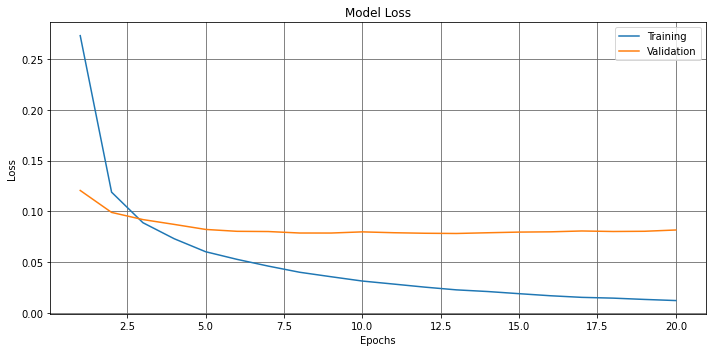

In [18]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(1, len(history.epoch) + 1)


plt.figure(figsize=(10,5))

plt.plot(epochs_range, acc, label='Training')
plt.plot(epochs_range, val_acc, label='Validation')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')
plt.grid(b=True, which='major', color='#666666', linestyle='-')
plt.tight_layout()
plt.show()

plt.figure(figsize=(10,5))

plt.plot(epochs_range, loss, label='Training')
plt.plot(epochs_range, val_loss, label='Validation')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Loss')
plt.grid(b=True, which='major', color='#666666', linestyle='-')
plt.tight_layout()
plt.show()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:17: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  app.launch_new_instance()


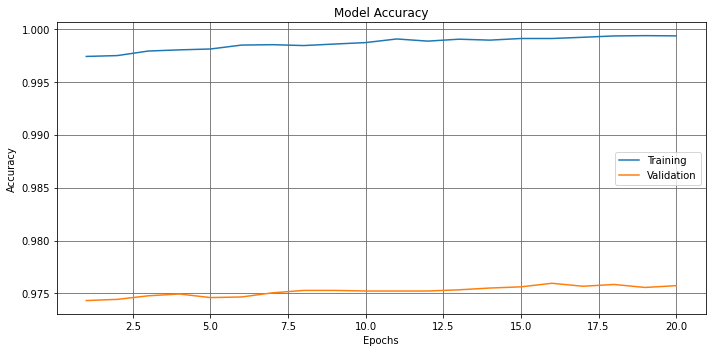

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:29: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.


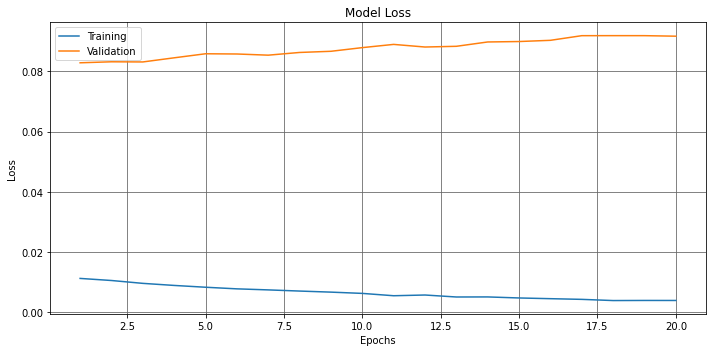

In [7]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(1, len(history.epoch) + 1)


plt.figure(figsize=(10,5))

plt.plot(epochs_range, acc, label='Training')
plt.plot(epochs_range, val_acc, label='Validation')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')
plt.grid(b=True, which='major', color='#666666', linestyle='-')
plt.tight_layout()
plt.show()

plt.figure(figsize=(10,5))

plt.plot(epochs_range, loss, label='Training')
plt.plot(epochs_range, val_loss, label='Validation')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Loss')
plt.grid(b=True, which='major', color='#666666', linestyle='-')
plt.tight_layout()
plt.show()

In [9]:
np.save('mobilenet_history_20e_2.npy',history.history)

In [ ]:
history=np.load('../input/my-data/vgg_history_20e.npy',allow_pickle='TRUE').item()
print(history.keys())
print(type(history))

In [ ]:
epochs = len(history.get('accuracy'))

acc = history.get('accuracy')
val_acc = history.get('val_accuracy')
loss = history.get('loss')
val_loss = history.get('val_loss')

epochs_range = range(1, epochs + 1)


plt.figure(figsize=(10,5))

plt.plot(epochs_range, acc, label='Training')
plt.plot(epochs_range, val_acc, label='Validation')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')
plt.grid(b=True, which='major', color='#666666', linestyle='-')
plt.tight_layout()
plt.show()

plt.figure(figsize=(10,5))

plt.plot(epochs_range, loss, label='Training')
plt.plot(epochs_range, val_loss, label='Validation')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Loss')
plt.grid(b=True, which='major', color='#666666', linestyle='-')
plt.tight_layout()
plt.show()

# Evaluation on test set

In [10]:
test_datagen = ImageDataGenerator(rescale=1./255)
test = test_datagen.flow_from_directory(directory='../input/large-gender-face-dataset/big_face_gender_data/Test',
                                          target_size=(218,178), batch_size=32,
                                          class_mode='binary', color_mode='rgb', shuffle=False)

Found 16779 images belonging to 2 classes.


In [11]:
predictions = []
labels = []
for i in range(len(test)):
    x, y = next(test)
    pre = model.predict(x)
    pre = [1 if x > 0.5 else 0 for x in pre]
    predictions.append(pre)
    labels.append(y)
predictions = np.concatenate(predictions)
labels = np.concatenate(labels)
print(len(predictions))

16779


              precision    recall  f1-score   support

         0.0       0.98      0.98      0.98      8320
         1.0       0.98      0.98      0.98      8459

    accuracy                           0.98     16779
   macro avg       0.98      0.98      0.98     16779
weighted avg       0.98      0.98      0.98     16779

Confusion matrix, without normalization
[[8157  163]
 [ 164 8295]]


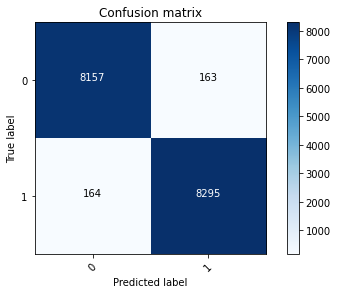

In [12]:
from sklearn.metrics import classification_report, confusion_matrix
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
   
#--------------------------------------------------------------------------------------------------
    
# Compute confusion matrix
cnf_matrix = confusion_matrix(labels, predictions, labels=[0,1])
np.set_printoptions(precision=2)

print (classification_report(labels, predictions))

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['0','1'],normalize= False,  title='Confusion matrix')

In [13]:
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score


# Tính accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(labels, predictions)
print('Accuracy: %f' % accuracy)
# Tính precision tp / (tp + fp)
precision = precision_score(labels, predictions, average='macro')
print('Precision: %f' % precision)
# Tính recall: tp / (tp + fn)
recall = recall_score(labels, predictions, average='macro')
print('Recall: %f' % recall)
# Tính f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(labels, predictions, average='macro')
print('F1 score: %f' % f1)
# Tính Area under ROC
auc = roc_auc_score(labels, predictions, multi_class='ovr')
print('ROC AUC: %f' % auc)

Accuracy: 0.980511
Precision: 0.980510
Recall: 0.980511
F1 score: 0.980510
ROC AUC: 0.980511


In [ ]:
# Saving model
model.save('mobilenet_20e_1.h5')
print('Done! Model Saved!')

In [5]:
# Load model
from tensorflow import keras
model = keras.models.load_model('../input/my-data/mobilenet_20e.h5')